# 3D Multi-organ Segmentation with Swin UNETR  (BTCV Challenge)


This tutorial uses a Swin UNETR [1] model for the task of multi-organ segmentation task using the BTCV challenge dataset. The architecture of Swin UNETR is demonstrated as below
![image](https://lh3.googleusercontent.com/pw/AM-JKLVx_J2DKYA7DCo3F_gGbK2e1sI_yzjYwQt-EWCirNGKsUv1hi7qLMofkY0r5xVXJNzhr8qenBkUJJYXtj49xsWJgOgbkBpcN7rz9axkeN3tgJbWldtZhYcBgYOlklzUS34eMCL-gRkxyFydJQ_Y1HAx=w1322-h518-no?authuser=2)

The following features are included in this tutorial:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. Swin UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

For this tutorial, the dataset needs to be downloaded from: https://www.synapse.org/#!Synapse:syn3193805/wiki/217752. 

In addition, the json file for data splits needs to be downloaded from this [link](https://drive.google.com/file/d/1t4fIQQkONv7ArTSZe4Nucwkk1KfdUDvW/view?usp=sharing). Once downloaded, place the json file in the same folder as the dataset. 

For BTCV dataset, under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kideny 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [Self-Supervised Pre-Training of Swin Transformers
for 3D Medical Image Analysis](https://arxiv.org/abs/2111.14791)

2. [Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images](https://arxiv.org/abs/2201.01266)

3. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

4. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

If you find this tutorial helpful, please consider citing [1] and [2]:

[1]: Tang, Y., Yang, D., Li, W., Roth, H.R., Landman, B., Xu, D., Nath, V. and Hatamizadeh, A., 2022. Self-supervised pre-training of swin transformers for 3d medical image analysis. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 20730-20740).

[2]: Hatamizadeh, A., Nath, V., Tang, Y., Yang, D., Roth, H. and Xu, D., 2022. Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images. arXiv preprint arXiv:2201.01266.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_btcv_segmentation_3d.ipynb)


# Pre-trained Swin UNETR Encoder

We use weights from self-supervised pre-training of Swin UNETR encoder (3D Swin Tranformer) on a cohort of 5050 CT scans from publicly available datasets. The encoder is pre-trained using reconstructin, rotation prediction and contrastive learning pre-text tasks as shown below. For more details, please refer to [1] (CVPR paper) and see this [repository](https://github.com/Project-MONAI/research-contributions/tree/main/SwinUNETR/Pretrain). 

![image](https://lh3.googleusercontent.com/pw/AM-JKLVLgduGZ9naCSasWg09U665NBdd3UD4eLTy15wJiwbmKLS_p5WSZ2MBcRePEJO2tv9X3TkC52MsbnomuPy5JT3vSVeCji1MOEuAzcsxily88TdbHuAt6PzccefwKupbXyOCumK5hzz5Ul38kZnlEQ84=w397-h410-no?authuser=2)

Please download the pre-trained weights from this [link](https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt) and place it in the root directory of this tutorial. 

If training from scratch is desired, please skip the step for initializing from pre-trained weights. 

## Setup environment

In [1]:
import torch
torch.cuda.empty_cache()

!nvidia-smi

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fri Jul 15 20:35:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:89:00.0 Off |                    0 |
| N/A   36C    P0    43W / 163W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install 'git+https://github.com/Project-MONAI/MONAI#egg.gitmonai@0.8.1+271.g07de215c'
!pip install monai==0.9.1rc3
!pip install nibabel==3.1.1
!pip install tqdm==4.63.0
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    ToDeviced,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1rc3
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.1.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.63.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.4
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpt26y6vq7


## Setup transforms for training and validation
To save on GPU memory utilization, the num_samples can be reduced to 2. 

In [3]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#        ToDeviced(keys=["image", "label"], device=device),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
       # ToDeviced(keys=["image", "label"], device=device),
        ToTensord(keys=["image", "label"]),
    ]
)

In [4]:
data_dir = "data/"
split_JSON = "dataset_0.json"

datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
# train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
# val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

Loading dataset: 100%|██████████| 6/6 [00:28<00:00,  4.78s/it]


## Check data shape and visualize

image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


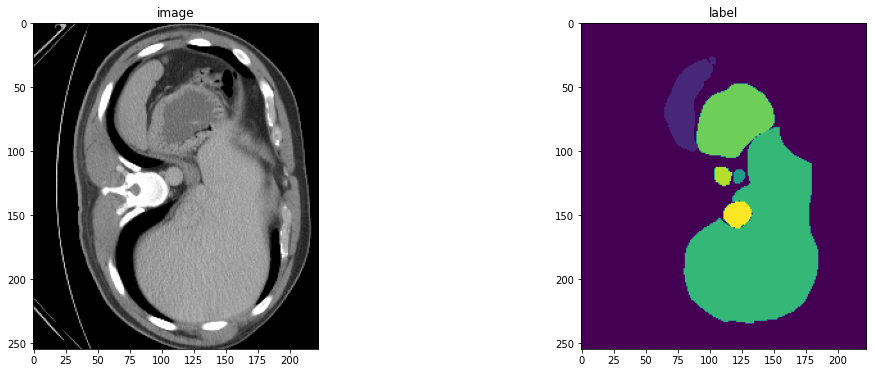

In [5]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 14-class multi-organ segmentation. We use a feature size of 48 which is compatible with self-supervised pre-trained weights. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. 

In [6]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

### Initialize Swin UNETR encoder from self-supervised pre-trained weights

In this section, we intialize the Swin UNETR encoder from weights downloaded from this [link](https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt). If training from scratch is desired, please skip this section.

In [7]:
weight = torch.load("./model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


### Optimizer and loss function

In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
begin = time.time()
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
end = time.time()
print(f"Total train time: {end - begin:.2f} seconds")
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Validate (X / X Steps) (dice=X.X):   0%|          | 0/6 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Validate (480 / 10 Steps): 100%|██████████| 6/6 [00:24<00:00,  4.07s/it]
positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
Training (500 / 30000 Steps) (loss=2.68251):  88%|████████▊ | 21/24 [00:45<00:25,  8.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.10523679107427597


Training (1000 / 30000 Steps) (loss=2.13638):  71%|███████   | 17/24 [00:38<00:52,  7.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.07569018751382828


Training (1500 / 30000 Steps) (loss=1.90171):  54%|█████▍    | 13/24 [00:35<01:23,  7.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.08025763183832169


Training (2500 / 30000 Steps) (loss=1.96714):  21%|██        | 5/24 [00:27<02:50,  8.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.07246538996696472


Training (3000 / 30000 Steps) (loss=1.91799):   4%|▍         | 1/24 [00:24<09:30, 24.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.09305248409509659


Training (3464 / 30000 Steps) (loss=1.96805):  33%|███▎      | 8/24 [00:09<00:15,  1.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (5000 / 30000 Steps) (loss=1.59737):  38%|███▊      | 9/24 [00:31<01:58,  7.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.07061345130205154


Training (5500 / 30000 Steps) (loss=1.56272):  21%|██        | 5/24 [00:28<02:51,  9.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.07060054689645767


Training (5883 / 30000 Steps) (loss=1.76143):  17%|█▋        | 4/24 [00:05<00:22,  1.10s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (7500 / 30000 Steps) (loss=1.72726):  54%|█████▍    | 13/24 [00:35<01:24,  7.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.08777529001235962


Training (8000 / 30000 Steps) (loss=1.91273):  38%|███▊      | 9/24 [00:32<01:58,  7.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.09312240034341812


Training (8500 / 30000 Steps) (loss=1.65908):  21%|██        | 5/24 [00:28<02:52,  9.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10523679107427597 Current Avg. Dice: 0.08893509954214096


Training (8517 / 30000 Steps) (loss=1.72599):  88%|████████▊ | 21/24 [00:44<00:02,  1.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (10000 / 30000 Steps) (loss=2.28292):  71%|███████   | 17/24 [00:40<00:54,  7.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.10929516702890396 Current Avg. Dice: 0.10929516702890396


Training (10500 / 30000 Steps) (loss=1.65427):  54%|█████▍    | 13/24 [00:35<01:23,  7.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10929516702890396 Current Avg. Dice: 0.10640474408864975


Training (11000 / 30000 Steps) (loss=1.61410):  38%|███▊      | 9/24 [00:32<01:57,  7.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.10929516702890396 Current Avg. Dice: 0.10596194118261337


Training (11173 / 30000 Steps) (loss=1.72598):  58%|█████▊    | 14/24 [00:14<00:08,  1.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (12500 / 30000 Steps) (loss=1.64012):  88%|████████▊ | 21/24 [00:42<00:22,  7.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.11252329498529434


Training (13000 / 30000 Steps) (loss=1.71191):  71%|███████   | 17/24 [00:39<00:52,  7.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.09339217096567154


Training (13500 / 30000 Steps) (loss=1.85141):  54%|█████▍    | 13/24 [00:35<01:23,  7.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.08462151885032654


Training (13823 / 30000 Steps) (loss=1.62583): 100%|██████████| 24/24 [00:23<00:00,  1.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (15500 / 30000 Steps) (loss=1.73282):  88%|████████▊ | 21/24 [00:42<00:22,  7.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.07921255379915237


Training (16000 / 30000 Steps) (loss=1.71104):  71%|███████   | 17/24 [00:38<00:52,  7.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.09620887041091919


Training (16500 / 30000 Steps) (loss=1.76284):  54%|█████▍    | 13/24 [00:35<01:23,  7.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.098011814057827


Training (17000 / 30000 Steps) (loss=2.06464):  38%|███▊      | 9/24 [00:31<01:57,  7.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.0814722552895546


Training (17500 / 30000 Steps) (loss=1.74886):  21%|██        | 5/24 [00:28<02:51,  9.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.08850126713514328


Training (18000 / 30000 Steps) (loss=1.67718):   4%|▍         | 1/24 [00:24<09:23, 24.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.08198585361242294


Training (18500 / 30000 Steps) (loss=1.63074):  88%|████████▊ | 21/24 [00:42<00:22,  7.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.07472795993089676


Training (19000 / 30000 Steps) (loss=1.78521):  71%|███████   | 17/24 [00:38<00:52,  7.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.08991578966379166


Training (19500 / 30000 Steps) (loss=1.67537):  54%|█████▍    | 13/24 [00:35<01:23,  7.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.07180359959602356


Training (20000 / 30000 Steps) (loss=1.81226):  38%|███▊      | 9/24 [00:31<01:57,  7.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.07197052240371704


Training (20500 / 30000 Steps) (loss=1.91721):  21%|██        | 5/24 [00:28<02:53,  9.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1141304075717926 Current Avg. Dice: 0.08904116600751877


Training (20965 / 30000 Steps) (loss=1.50596):  58%|█████▊    | 14/24 [00:14<00:10,  1.06s/it]

KeyboardInterrupt



In [12]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8452 at iteration: 28500


In [35]:
torch.cuda.empty_cache()

!nvidia-smi

Fri Jul 15 04:29:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:89:00.0 Off |                    0 |
| N/A   38C    P0    48W / 163W |  32494MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-32GB-LS'

### Plot the loss and metric

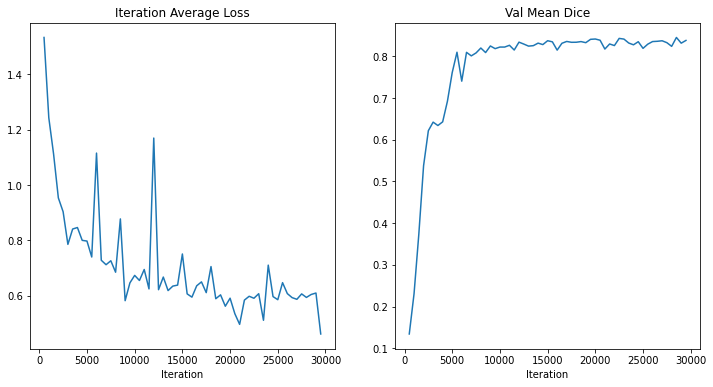

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

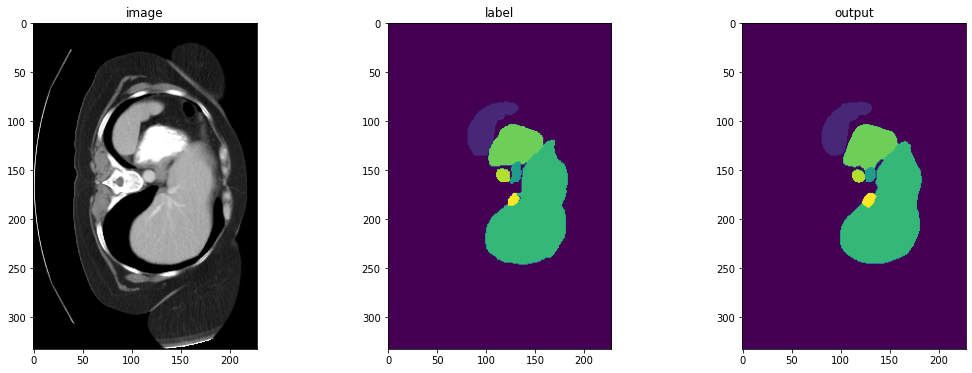

In [14]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [15]:
if directory is None:
    shutil.rmtree(root_dir)